In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc
import operator

In [2]:
sns.set_context('talk')

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [5]:
from os import listdir
from os.path import isfile, join
stacking_dir = 'stacking'
results_dir = 'results'
stacking_files = [f for f in listdir(stacking_dir) if isfile(join(stacking_dir, f)) if f.endswith('lmse.csv')]

In [6]:
stacking_files

['xbg_tune_eta015_num300_lmse.csv',
 'xbg_tune_eta015_num300_with_size_dropped_lmse.csv',
 'xbg_tune_eta015_num300_dropped_lmse.csv']

In [7]:
dfXtrain = pd.concat([pd.read_csv(join(stacking_dir, f), index_col='ID', sep=';') for f in stacking_files], axis=1)
dfXtest = pd.concat([pd.read_csv(join(results_dir, f), index_col='ID', sep=';') for f in stacking_files], axis=1)
dfXtest.columns = dfXtrain.columns
dfYtrain = pd.read_csv('preprocessed_csv/y_train_tree.csv', header=None, names=['ID', 'COTIS'], sep=';')

In [8]:
dfYtrain = dfYtrain.set_index('ID')

In [9]:
department = pd.read_csv('preprocessed_csv/train_tree.csv', index_col='id', sep=';')['department']

# Preprocessing

In [10]:
y_train = np.array(dfYtrain)
x_train = np.log(np.array(dfXtrain))
x_test = np.log(np.array(dfXtest))

# Save routines

In [11]:
model_name = 'COTIS'
dfYtest = pd.DataFrame({'ID': dfXtest.index, model_name: np.zeros(dfXtest.shape[0])})
dfYtest = dfYtest[['ID', model_name]]
dfYtest.head()

,ID,COTIS
0,300001,0.0
1,300002,0.0
2,300003,0.0
3,300004,0.0
4,300005,0.0


In [12]:
def save_to_file(y, file_name):
    dfYtest[model_name] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False, sep=';')

# Train XGB

In [13]:
from sklearn.cross_validation import LabelKFold

In [14]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(10, 6))
    plt.plot(params[param_name], means)
    plt.fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

In [15]:
def mape(y_true, y_pred): 
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
def mape_scorer(est, X, y):
    gc.collect()
    return mape(y, est.predict(X))

In [17]:
class MyGS():
    class Element():
        def __init__(self):
            self.cv_validation_scores = []
        
        
        def add(self, score):
            self.cv_validation_scores.append(score)
    
    
    def __init__(self, param_grid, name, n_folds):
        self.param_grid = {name: param_grid}
        self.grid_scores_ = [MyGS.Element() for item in param_grid]
        
    
    def add(self, score, param_num):
        self.grid_scores_[param_num].add(score)
        

In [18]:
def amse(preds, dtrain, alpha=1, beta=1, gamma=1, divider=1):
    labels = dtrain.get_label()
    labels2 = np.power(labels, 2)
    grad = np.where(preds > labels, 
                    alpha * (preds - labels) / labels2 - gamma, 
                    alpha * (preds - labels) / (labels2 * divider) + gamma)
    second_grad = beta * np.where(preds > labels, 1, 1 / divider) / labels2
    return grad, second_grad

In [19]:
def amse_fixed(alpha, beta, gamma, divider):
    def wrapper(*args, **kwargs):
        return amse(*args, alpha=alpha, beta=beta, gamma=gamma, divider=divider, **kwargs)
    return wrapper

Подберём веса

In [25]:
%%time

n_folds = 10
label_kfold = LabelKFold(np.array(department), n_folds=n_folds)
weight_list = [(alpha, beta, 1 - alpha - beta) 
               for alpha in np.arange(0.01, 1, 0.01)
               for beta in np.arange(0.01, 1 - alpha, 0.01) 
               ]
scores = [-100 for i in range(n_folds)]
train_scores = [-100 for i in range(n_folds)]
weights = [0 for i in range(n_folds)]

for fold_index, (train_index, test_index) in enumerate(label_kfold):
    X = x_train[train_index]
    y = y_train[train_index][:, 0]
    X_validation = x_train[test_index]
    y_validation = y_train[test_index][:, 0]
    good_score = -np.Inf
    good_weight = None
    for weight in weight_list:
        #wX = X / weight
        #y_pred = X.flatten()[np.argmin(wX, axis=1) + np.arange(X.shape[0]) * X.shape[1]]
        y_pred = np.exp(np.sum(X * weight, axis=1))
        score = mape(y, y_pred)
        if score > good_score:
            good_score = score
            good_weight = weight
    #wX = X_validation / good_weight
    #y_pred = X_validation.flatten()[np.argmin(wX, axis=1) + np.arange(X_validation.shape[0]) * X_validation.shape[1]]
    y_pred = np.exp(np.sum(X_validation * good_weight, axis=1))
    scores[fold_index] = mape(y_validation, y_pred)
    train_scores[fold_index] = good_score
    weights[fold_index] = good_weight   

CPU times: user 15min 59s, sys: 945 ms, total: 16min
Wall time: 16min 3s


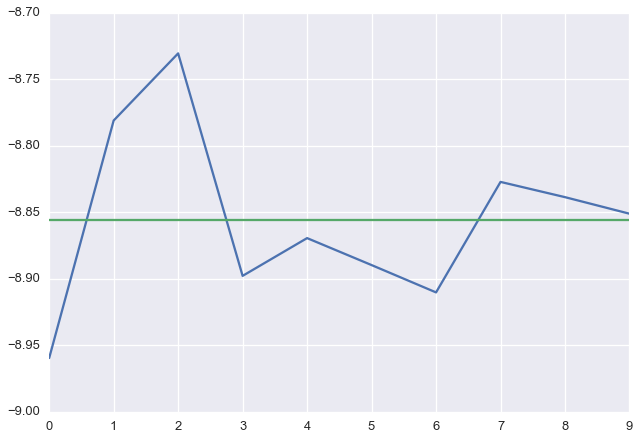

In [26]:
plt.plot(train_scores)
mean = np.mean(train_scores)
plt.plot([mean for i in train_scores])

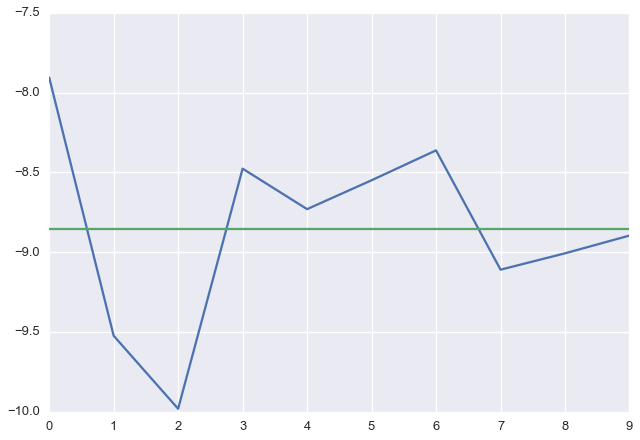

In [27]:
plt.plot(scores)
mean = np.mean(scores)
plt.plot([mean for i in scores])

In [28]:
weights

[(0.35000000000000003, 0.34000000000000002, 0.30999999999999989),
 (0.34000000000000002, 0.35000000000000003, 0.30999999999999989),
 (0.35000000000000003, 0.34000000000000002, 0.30999999999999989),
 (0.36000000000000004, 0.35000000000000003, 0.28999999999999987),
 (0.37, 0.34000000000000002, 0.28999999999999998),
 (0.35000000000000003, 0.33000000000000002, 0.3199999999999999),
 (0.36000000000000004, 0.33000000000000002, 0.30999999999999989),
 (0.36000000000000004, 0.34000000000000002, 0.29999999999999988),
 (0.37, 0.33000000000000002, 0.29999999999999999),
 (0.37, 0.34000000000000002, 0.28999999999999998)]

In [29]:
mean

-8.8545344831078765

In [34]:
np.mean(weights, axis=0)

array([ 0.358,  0.339,  0.303])

Попробуем подобрать, на который стоит домжножать, чтобы скостить скор

In [48]:
weight = np.array([ 0.358,  0.339,  0.303])

In [49]:
wX = x_train * weight
#one_x = x_train.flatten()[np.argmin(wX, axis=1) + np.arange(x_train.shape[0]) * x_train.shape[1]]
one_x = np.exp(np.sum(wX, axis=1))

In [50]:
onex = one_x.reshape((one_x.shape[0], 1))

In [51]:
%%time

n_folds = 10
label_kfold = LabelKFold(np.array(department), n_folds=n_folds)
weight_list = [w for w in np.arange(0.8, 1.2, 0.001)
               ]
scores = [-100 for i in range(n_folds)]
train_scores = [-100 for i in range(n_folds)]
weights = [0 for i in range(n_folds)]

for fold_index, (train_index, test_index) in enumerate(label_kfold):
    X = onex[train_index]
    y = y_train[train_index][:, 0]
    X_validation = onex[test_index]
    y_validation = y_train[test_index][:, 0]
    good_score = -np.Inf
    good_weight = None
    for weight in weight_list:
        y_pred = X[:, 0] * weight
        score = mape(y, y_pred)
        if score > good_score:
            good_score = score
            good_weight = weight
    y_pred = X_validation[:, 0] * good_weight
    scores[fold_index] = mape(y_validation, y_pred)
    train_scores[fold_index] = good_score
    weights[fold_index] = good_weight   

CPU times: user 14.9 s, sys: 9 µs, total: 14.9 s
Wall time: 14.9 s


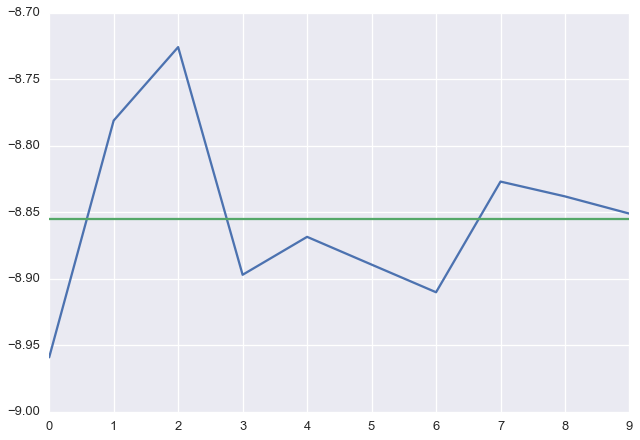

In [52]:
plt.plot(train_scores)
mean = np.mean(train_scores)
plt.plot([mean for i in train_scores])

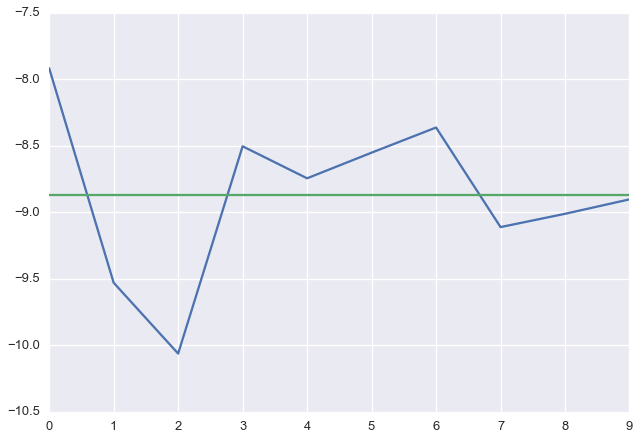

In [53]:
plt.plot(scores)
mean = np.mean(scores)
plt.plot([mean for i in scores])

In [54]:
weights

[1.0010000000000003,
 1.0010000000000003,
 0.99600000000000022,
 1.0020000000000002,
 0.99800000000000022,
 0.99900000000000022,
 0.99900000000000022,
 0.99900000000000022,
 0.99900000000000022,
 1.0010000000000003]

In [55]:
mean

-8.8702564030029745

# Save

In [56]:
weight = np.array([ 0.358,  0.339,  0.303])

In [57]:
wX = x_test * weight
y_pred = 0.999 * np.exp(np.sum(wX, axis=1))

In [58]:
save_to_file(y_pred, 'lmse_weight_log_stacking.csv')